In [81]:
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
import seaborn as sns

In [84]:
# Read the gen1 dfset with custom date parser
gen = pd.read_csv('data/Plant_1_Generation_Data.csv', 
                   parse_dates=['DATE_TIME'], 
                   date_parser=lambda x: datetime.strptime(x, '%d-%m-%Y %H:%M'))

# Read the wea1 dfset, assuming standard date format
wea = pd.read_csv('data/Plant_1_Weather_Sensor_Data.csv', 
                   parse_dates=['DATE_TIME'],
                   date_parser=lambda x: datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))

In [85]:
# Merge on DATE_TIME
data = pd.merge(gen, wea, on='DATE_TIME')


In [65]:
data.DATE_TIME

0       2020-05-15 00:00:00
1       2020-05-15 00:00:00
2       2020-05-15 00:00:00
3       2020-05-15 00:00:00
4       2020-05-15 00:00:00
                ...        
68769   2020-06-17 23:45:00
68770   2020-06-17 23:45:00
68771   2020-06-17 23:45:00
68772   2020-06-17 23:45:00
68773   2020-06-17 23:45:00
Name: DATE_TIME, Length: 68774, dtype: datetime64[ns]

In [86]:
# Convert DATE_TIME to datetime format and extract date
data['DATE_TIME'] = pd.to_datetime(data['DATE_TIME'])
data['DATE'] = data['DATE_TIME'].dt.date

# Aggregating data by day
daily_data = data.groupby('DATE').agg({'DAILY_YIELD':'sum'}).reset_index()

# Splitting the dataset into training and test sets
test_data = daily_data.iloc[-4:]
train_data = daily_data.iloc[:-4]

# Display the first few rows of the aggregated daily data
train_data.head(), test_data


(         DATE   DAILY_YIELD
 0  2020-05-15  5.053591e+06
 1  2020-05-16  6.699905e+06
 2  2020-05-17  7.804065e+06
 3  2020-05-18  5.130290e+06
 4  2020-05-19  5.896321e+06,
           DATE   DAILY_YIELD
 30  2020-06-14  7.240643e+06
 31  2020-06-15  7.137433e+06
 32  2020-06-16  6.512585e+06
 33  2020-06-17  6.138883e+06)

In [73]:
!pip install statsmodels

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.9/9.9 MB 43.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.9/233.9 kB 8.0 MB/s eta 0:00:00

[notice] A new release of pip available: 22.2.2 -> 23.3.1
[notice] To update, run: pip install --upgrade pip


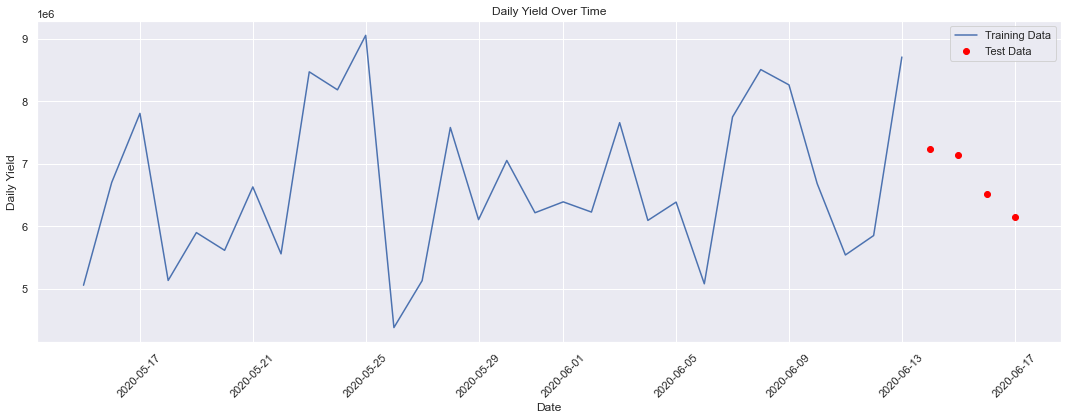

In [88]:
# Setting plot style
sns.set(style="darkgrid")

# Plotting the daily yield
plt.figure(figsize=(15, 6))
plt.plot(train_data['DATE'], train_data['DAILY_YIELD'], label='Training Data')
plt.scatter(test_data['DATE'], test_data['DAILY_YIELD'], color='red', label='Test Data')
plt.title('Daily Yield Over Time')
plt.xlabel('Date')
plt.ylabel('Daily Yield')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Given the nature of the data, we use the ARIMA model for forecasting.
We determine the optimal parameters for the ARIMA model by analyzing the autocorrelation and partial autocorrelation plots.

{'ADF Statistic': -4.375179854730781,
 'p-value': 0.0003283377778905891,
 'Critical Values': {'1%': -3.6996079738860943,
  '5%': -2.9764303469999494,
  '10%': -2.627601001371742}}

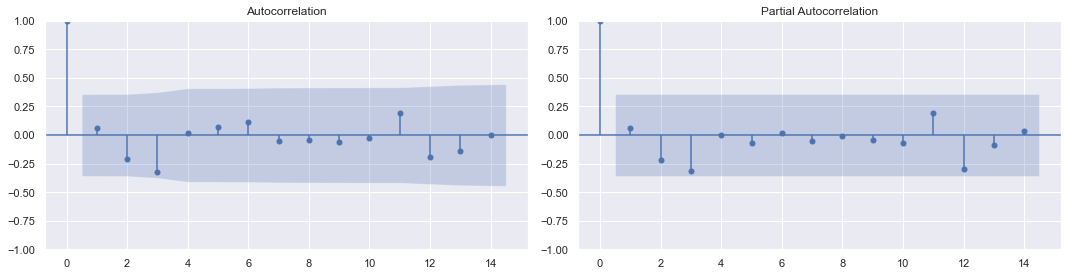

In [92]:
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Augmented Dickey-Fuller test to check stationarity
adf_test = adfuller(train_data['DAILY_YIELD'])

# Adjusting the number of lags for the PACF plot
max_lags = min(20, len(train_data) // 2 - 1)

# ACF and PACF plots with adjusted lags
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
plot_acf(train_data['DAILY_YIELD'], lags=max_lags, ax=ax1)
plot_pacf(train_data['DAILY_YIELD'], lags=max_lags, ax=ax2)
plt.tight_layout()

# ADF test result
adf_test_result = {
    'ADF Statistic': adf_test[0],
    'p-value': adf_test[1],
    'Critical Values': adf_test[4]
}

# Displaying ADF test result
adf_test_result



Since the ADF statistic is less than the critical values at the 1%, 5%, and 10% levels, and the p-value is significantly low, we can reject the null hypothesis that the series has a unit root. This indicates that the series is stationary.

Let's proceed with fitting an ARIMA model to the data. The choice of ARIMA parameters (p, d, q) will be based on the ACF and PACF plots we examined earlier:

p: The number of lag observations in the model (lag order). This can be inferred from the PACF plot.
d: The degree of differencing. Based on the ADF test, we know that d=0 since the series is already stationary.
q: The size of the moving average window (order of moving average). This can be inferred from the ACF plot.

In [94]:
from statsmodels.tsa.arima.model import ARIMA
import numpy as np

# Initial ARIMA Model parameters based on ACF and PACF plots
p = 1  # lag order
d = 0  # degree of differencing
q = 1  # order of moving average

# Fitting the ARIMA model
arima_model = ARIMA(train_data['DAILY_YIELD'], order=(p, d, q))
arima_model_fit = arima_model.fit()

# Forecasting the next 4 days (the test set period)
forecast = arima_model_fit.forecast(steps=4)

# Adding forecast to the test data for comparison
test_data_with_forecast = test_data.copy()
test_data_with_forecast['Forecast'] = np.array(forecast)

test_data_with_forecast


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


,DATE,DAILY_YIELD,Forecast
30,2020-06-14,7.240643e+06,6.880217e+06
31,2020-06-15,7.137433e+06,6.611548e+06
32,2020-06-16,6.512585e+06,6.662824e+06
33,2020-06-17,6.138883e+06,6.653038e+06


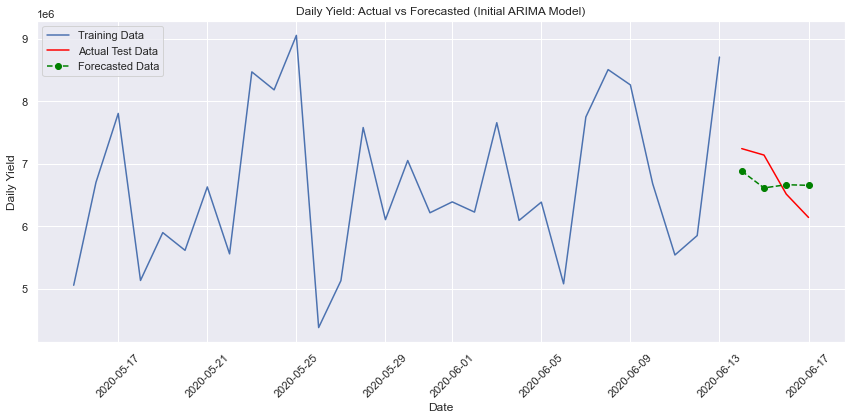

In [95]:
# Plotting the actual vs forecasted values
plt.figure(figsize=(12, 6))
plt.plot(train_data['DATE'], train_data['DAILY_YIELD'], label='Training Data')
plt.plot(test_data_with_forecast['DATE'], test_data_with_forecast['DAILY_YIELD'], color='red', label='Actual Test Data')
plt.plot(test_data_with_forecast['DATE'], test_data_with_forecast['Forecast'], color='green', linestyle='--', marker='o', label='Forecasted Data')
plt.title('Daily Yield: Actual vs Forecasted (Initial ARIMA Model)')
plt.xlabel('Date')
plt.ylabel('Daily Yield')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [96]:
train_data

,DATE,DAILY_YIELD
0,2020-05-15,5.053591e+06
1,2020-05-16,6.699905e+06
2,2020-05-17,7.804065e+06
3,2020-05-18,5.130290e+06
4,2020-05-19,5.896321e+06
5,2020-05-20,5.612536e+06
6,2020-05-21,6.627303e+06
7,2020-05-22,5.555931e+06
8,2020-05-23,8.468993e+06
9,2020-05-24,8.181251e+06


In [98]:
# New model, Random Forest Regressor

plant_data = data.copy()

# Feature Engineering
plant_data['hour'] = plant_data['DATE_TIME'].dt.hour
plant_data['minute'] = plant_data['DATE_TIME'].dt.minute
plant_data['day_of_week'] = plant_data['DATE_TIME'].dt.dayofweek
plant_data['day_of_year'] = plant_data['DATE_TIME'].dt.dayofyear

# Checking the first few rows to confirm the new features
plant_data.head()


,DATE_TIME,PLANT_ID_x,SOURCE_KEY_x,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,PLANT_ID_y,SOURCE_KEY_y,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION,DATE,hour,minute,day_of_week,day_of_year
0,2020-05-15,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,2020-05-15,0,0,4,136
1,2020-05-15,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,2020-05-15,0,0,4,136
2,2020-05-15,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,2020-05-15,0,0,4,136
3,2020-05-15,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,2020-05-15,0,0,4,136
4,2020-05-15,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0,2020-05-15,0,0,4,136


In [99]:
# Determine the cutoff date for the last four days
cutoff_date = plant_data['DATE_TIME'].max() - pd.Timedelta(days=4)

# Splitting the data into training and testing sets
train_data = plant_data[plant_data['DATE_TIME'] <= cutoff_date]
test_data = plant_data[plant_data['DATE_TIME'] > cutoff_date]

# Verifying the splitting
train_data_end = train_data['DATE_TIME'].max()
test_data_start = test_data['DATE_TIME'].min()

train_data_end, test_data_start, test_data['DATE_TIME'].max()


(Timestamp('2020-06-13 23:45:00'),
 Timestamp('2020-06-14 00:00:00'),
 Timestamp('2020-06-17 23:45:00'))

In [100]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import numpy as np

# Example: Selecting data for one solar panel
panel_key = plant_data['SOURCE_KEY_x'].unique()[0]
panel_data = train_data[train_data['SOURCE_KEY_x'] == panel_key]

# Preparing the data for training
X = panel_data[['hour', 'minute', 'day_of_week', 'day_of_year', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']]
y = panel_data['DAILY_YIELD']

# Train-test split for model validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Model training
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Model validation
y_pred = rf_model.predict(X_val)
mse = mean_squared_error(y_val, y_pred)

mse, np.sqrt(mse)  # Mean Squared Error and Root Mean Squared Error


(33022.6839358823, 181.72144599876563)

In [103]:
# Preparing the test data for the example solar panel
test_panel_data = test_data[test_data['SOURCE_KEY_x'] == panel_key]
X_test = test_panel_data[['hour', 'minute', 'day_of_week', 'day_of_year', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']]

# Forecasting
test_predictions = rf_model.predict(X_test)

# Adding predictions to the test data for comparison
test_panel_data['Predicted_DAILY_YIELD'] = test_predictions

# Displaying some of the predicted values
test_panel_data[['DATE_TIME', 'DAILY_YIELD', 'Predicted_DAILY_YIELD']].head(10)


/var/folders/rj/0l5r7pjx2xj6_8gjscjxpvym0000gn/T/ipykernel_12007/665992991.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_panel_data['Predicted_DAILY_YIELD'] = test_predictions


,DATE_TIME,DAILY_YIELD,Predicted_DAILY_YIELD
60370,2020-06-14 00:00:00,998.0,342.819107
60392,2020-06-14 00:15:00,0.0,0.000000
60414,2020-06-14 00:30:00,0.0,0.000000
60436,2020-06-14 00:45:00,0.0,0.000000
60458,2020-06-14 01:00:00,0.0,0.000000
60480,2020-06-14 01:15:00,0.0,0.000000
60502,2020-06-14 01:30:00,0.0,0.000000
60524,2020-06-14 01:45:00,0.0,0.000000
60546,2020-06-14 02:00:00,0.0,7.388750
60568,2020-06-14 02:15:00,0.0,0.000000


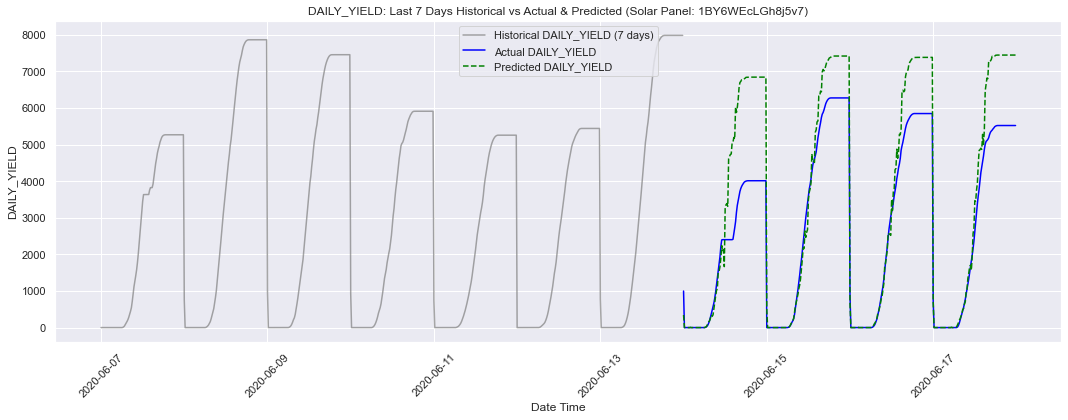

In [105]:
# Limiting the historical data to the 7 days prior to the test period
historical_cutoff = test_data_start - pd.Timedelta(days=7)
historical_data = plant_data[(plant_data['SOURCE_KEY_x'] == panel_key) & 
                             (plant_data['DATE_TIME'] >= historical_cutoff) & 
                             (plant_data['DATE_TIME'] <= train_data_end)]

# Plotting the actual vs predicted values for the limited historical data and the test data
plt.figure(figsize=(15, 6))

# Plotting limited historical data
plt.plot(historical_data['DATE_TIME'], historical_data['DAILY_YIELD'], label='Historical DAILY_YIELD (7 days)', color='gray', alpha=0.7)

# Plotting test data (actual and predicted)
plt.plot(test_panel_data['DATE_TIME'], test_panel_data['DAILY_YIELD'], label='Actual DAILY_YIELD', color='blue')
plt.plot(test_panel_data['DATE_TIME'], test_panel_data['Predicted_DAILY_YIELD'], label='Predicted DAILY_YIELD', color='green', linestyle='--')

plt.title(f'DAILY_YIELD: Last 7 Days Historical vs Actual & Predicted (Solar Panel: {panel_key})')
plt.xlabel('Date Time')
plt.ylabel('DAILY_YIELD')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()


In [106]:
# Identifying unique solar panels
unique_panels = plant_data['SOURCE_KEY_x'].unique()

# Dictionary to hold models for each panel
panel_models = {}

# Training a model for each solar panel
for panel in unique_panels:
    panel_train_data = train_data[train_data['SOURCE_KEY_x'] == panel]
    X_train = panel_train_data[['hour', 'minute', 'day_of_week', 'day_of_year', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']]
    y_train = panel_train_data['DAILY_YIELD']

    # Training the Random Forest model
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Storing the model
    panel_models[panel] = model

# Forecasting for each panel
panel_forecasts = {panel: model.predict(test_data[test_data['SOURCE_KEY_x'] == panel][['hour', 'minute', 'day_of_week', 'day_of_year', 'AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']])
                   for panel, model in panel_models.items()}

# Verifying forecasts for one of the panels
next(iter(panel_forecasts.values()))[:5]  # Displaying first 5 predictions of one panel


array([384.16017859,   0.        ,   0.        ,   0.        ,
         0.        ])

In [107]:
# Aggregating and calculating the average production for all panels
# First, combine all forecasts into a DataFrame
forecast_df = pd.DataFrame(panel_forecasts)
forecast_df['DATE_TIME'] = test_data[test_data['SOURCE_KEY_x'] == unique_panels[0]]['DATE_TIME'].values

# Calculating the average production for each 15-minute interval
forecast_df['Average_Predicted_Yield'] = forecast_df[unique_panels].mean(axis=1)

# Displaying a snippet of the aggregated predictions
forecast_df[['DATE_TIME', 'Average_Predicted_Yield']].head()


,DATE_TIME,Average_Predicted_Yield
0,2020-06-14 00:00:00,277.979740
1,2020-06-14 00:15:00,1.087784
2,2020-06-14 00:30:00,0.752557
3,2020-06-14 00:45:00,0.752557
4,2020-06-14 01:00:00,0.000000


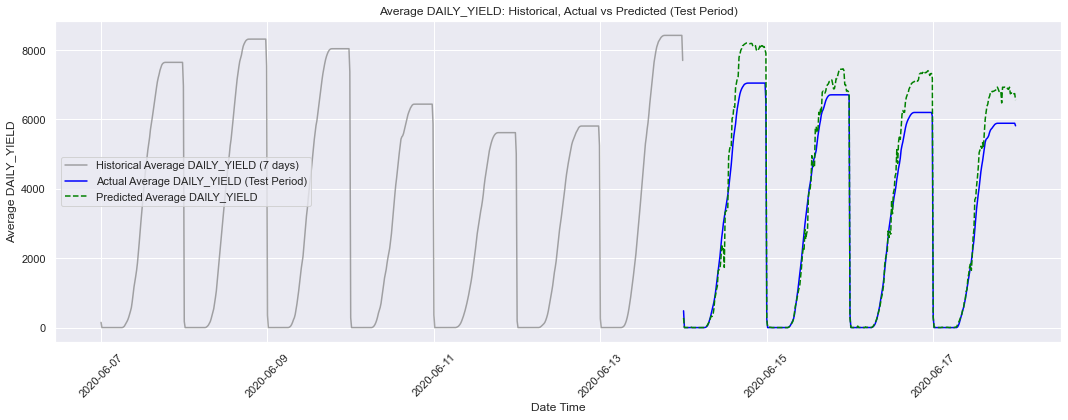

In [109]:
# Calculating the actual average DAILY_YIELD for the test period
actual_avg_test_data = test_data.groupby('DATE_TIME').mean().reset_index()

# Plotting the actual vs predicted values for the historical and test data
plt.figure(figsize=(15, 6))

# Plotting limited historical data (average)
plt.plot(historical_avg_data['DATE_TIME'], historical_avg_data['DAILY_YIELD'], label='Historical Average DAILY_YIELD (7 days)', color='gray', alpha=0.7)

# Plotting actual average data for the test period
plt.plot(actual_avg_test_data['DATE_TIME'], actual_avg_test_data['DAILY_YIELD'], label='Actual Average DAILY_YIELD (Test Period)', color='blue')

# Plotting aggregated predictions for the test period
plt.plot(forecast_df['DATE_TIME'], forecast_df['Average_Predicted_Yield'], label='Predicted Average DAILY_YIELD', color='green', linestyle='--')

plt.title('Average DAILY_YIELD: Historical, Actual vs Predicted (Test Period)')
plt.xlabel('Date Time')
plt.ylabel('Average DAILY_YIELD')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
